In [1]:
# Import libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [21]:
# Import data
survey_data = pd.read_csv('nonvoters_data.csv')

In [22]:
# Make data categorical
survey_data = survey_data.astype('category')

# Remove meaningless survey inputs and questions not of interest
survey_data.loc[:,'Q2_1':'Q18_10'] = survey_data.loc[:,'Q2_1':'Q18_10'].replace(-1, np.nan)
survey_data.loc[:,'Q23':'Q27_6'] = survey_data.loc[:,'Q23':'Q27_6'].replace(-1, np.nan)
survey_data.loc[:,'Q30'] = survey_data.loc[:,'Q30'].replace(-1, np.nan)
survey_data.loc[:,'Q19_1':'Q19_10'] = survey_data.loc[:,'Q19_1':'Q19_10'].replace(-1,0)
survey_data = survey_data.drop(['Q20','Q21','Q22','Q28_1','Q28_1','Q28_2','Q28_3','Q28_4','Q28_5','Q28_6','Q28_7','Q28_8','Q29_1','Q29_2',\
                  'Q29_3','Q29_4','Q29_5','Q29_6','Q29_7','Q29_8','Q29_9','Q29_10','Q31','Q32','Q33', 'Q26'], axis = 1)
direct_voting_q = ['Q2_1','Q2_3','Q25','Q23','Q27_1', 'Q27_2', 'Q27_3', 'Q27_4', 'Q27_5', 'Q27_6']
survey_data = survey_data.drop(direct_voting_q, axis = 1)

# Remove rows with missing data
survey_data = survey_data.dropna(axis = 0)

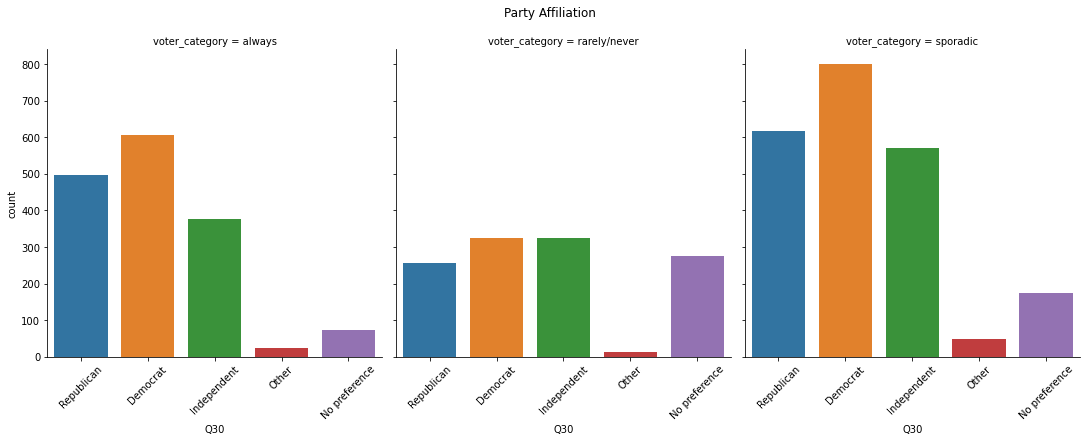

In [23]:
# Visualize Data
g = sns.catplot(x = "Q30", data = survey_data, col = 'voter_category', kind = 'count')
g.fig.suptitle("Party Affiliation", y=1.05)
g.set_xticklabels(['Republican','Democrat','Independent','Other', 'No preference'], rotation = 45)

In [24]:
# Check class frequency
survey_data.voter_category.value_counts()
# survey_data.shape

sporadic        2211
always          1577
rarely/never    1192
Name: voter_category, dtype: int64

In [25]:
# Need to downsample sporadic and always voters
from sklearn.utils import resample, shuffle

# Separate dataset by class
df_spor = survey_data[survey_data.voter_category == 'sporadic']
df_always = survey_data[survey_data.voter_category == 'always']
df_never = survey_data[survey_data.voter_category == 'rarely/never']

# Downsample majority classes without replacement
df_never_ds = resample(df_never, replace = False, n_samples = 1106, random_state = 25)
df_always_ds = resample(df_always, replace = False, n_samples = 1106, random_state = 25)

# Recombine datasets and shuffle
survey_data_ds = pd.concat([df_spor, df_always_ds, df_never_ds])
survey_data_ds = shuffle(survey_data_ds, random_state = 25)
survey_data_ds.voter_category.value_counts()

sporadic        2211
rarely/never    1106
always          1106
Name: voter_category, dtype: int64

In [27]:
# Need to encode string variables into integers
from sklearn.preprocessing import OrdinalEncoder

def encode_inputs(df, column, order='auto'):
    new_col_name = str(column + "_code")
    oe = OrdinalEncoder(categories = order)
    df[new_col_name] = oe.fit_transform(df[[column]])
    return df

survey_data_ds = encode_inputs(survey_data_ds, 'educ', [["High school or less", "Some college","College"]])
survey_data_ds = encode_inputs(survey_data_ds, 'income_cat', [["Less than $40k", "$40-75k","$75-125k","$125k or more"]])
# survey_data_ds = encode_inputs(survey_data_ds, 'voter_category', [["rarely/never","always"], ["sporadic"]])
survey_data_ds = encode_inputs(survey_data_ds, 'race')
survey_data_ds = encode_inputs(survey_data_ds, 'gender')

survey_data_ds["voter_category_code"] = np.where(survey_data_ds['voter_category'].str.contains("sporadic"), 1, 0)

In [28]:
# Split data intro trainging and testing set
from sklearn.model_selection import train_test_split

train, test = train_test_split(survey_data_ds, test_size = 0.2, random_state = 25)

X_train = train.iloc[:,2:89].drop(['educ','income_cat','voter_category','race','gender','ppage', 'voter_category_code'], axis=1)
y_train = train['voter_category_code']

X_test = test.iloc[:,2:89].drop(['educ','income_cat','voter_category','race','gender','ppage', 'voter_category_code'], axis=1)
y_test = test['voter_category_code']

In [ ]:
# Training Model

In [46]:
def model_train(model, i):
    fs = SelectKBest(score_func = chi2, k=i)
    X_train_fs = fs.fit_transform(X_train, y_train)
    model.fit(X_train_fs, y_train)
    X_test_fs = fs.transform(X_test)
    y_fitted = model.predict(X_test_fs)
    return y_fitted

def plot_test(range_of_accuracies):
    # Plot accuracies
    num = np.array(range(1, len(range_of_accuracies)+1))
    sqr = np.array(range_of_accuracies)

    d = {'num_features': num, 'accuracies': sqr}
    acc_num = pd.DataFrame(d)
    sns.lineplot(x = num, y = sqr, data = acc_num)

    # Find numbers of features giving maximum accuracyu
    optimal_feat_length = acc_num.iloc[acc_num['accuracies'].idxmax()]
    print(optimal_feat_length)

## Gaussian Naive Bayes

num_features     5.000000
accuracies      56.836158
Name: 4, dtype: float64


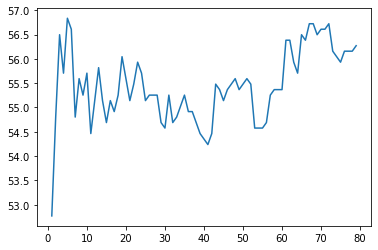

In [52]:
# Feature selection using Chi-square test
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_selection import mutual_info_classif
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score

range_of_accuracies = []

for i in range(1,len(X_test.columns)):
    gnb = GaussianNB()
    y_fitted = model_train(gnb, i)
    accuracy = accuracy_score(y_test, y_fitted)
    range_of_accuracies.append(accuracy*100)

plot_test(range_of_accuracies)

In [54]:
# Train model with number of features resulting in maximum accuracy
from sklearn.metrics import f1_score

gnb = GaussianNB()

y_fitted = model_train(gnb, 5)

# Investigate F1 score of model
f1_score(y_test, y_fitted, average = None, labels = [0.0, 1.0])

array([0.47956403, 0.63127413])

## SVM Classifier

num_features    31.000000
accuracies      58.305085
Name: 30, dtype: float64


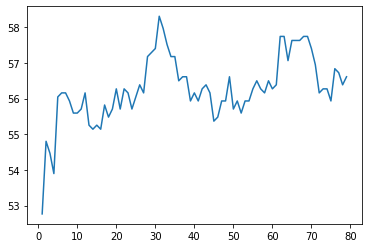

In [56]:
# Feature selection using Chi-square test
from sklearn.svm import SVC

range_of_accuracies = []

for i in range(1,len(X_test.columns)):
    clf_svc = SVC(kernel = 'linear')
    y_fitted = model_train(clf_svc, i)
    accuracy = accuracy_score(y_test, y_fitted)
    range_of_accuracies.append(accuracy*100)

plot_test(range_of_accuracies)

In [57]:
# Train model with number of features resulting in maximum accuracy

clf_svc = SVC(kernel = 'linear')

y_fitted = model_train(clf_svc, 31)

# Investigate F1 score of model
f1_score(y_test, y_fitted, average = None, labels = [0.0, 1.0])    

array([0.50865513, 0.63788027])

## Decision Tree Classifier

num_features     4.000000
accuracies      56.723164
Name: 3, dtype: float64


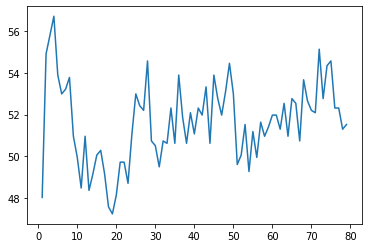

In [59]:
from sklearn.tree import DecisionTreeClassifier

range_of_accuracies = []

for i in range(1,len(X_test.columns)):
    clf_dec = DecisionTreeClassifier()
    y_fitted = model_train(clf_dec, i)
    accuracy = accuracy_score(y_test, y_fitted)
    range_of_accuracies.append(accuracy*100)

plot_test(range_of_accuracies)

In [60]:
# Train model with number of features resulting in maximum accuracy

clf_dec = DecisionTreeClassifier()

y_fitted = model_train(clf_dec, 4)

# Investigate F1 score of model
f1_score(y_test, y_fitted, average = None, labels = [0.0, 1.0])    

array([0.5346294 , 0.59556494])

## Logistic Regression

C:\Users\oreil\AppData\Local\conda\conda\envs\Voting\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\oreil\AppData\Local\conda\conda\envs\Voting\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit

num_features    33.000000
accuracies      56.610169
Name: 32, dtype: float64


C:\Users\oreil\AppData\Local\conda\conda\envs\Voting\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


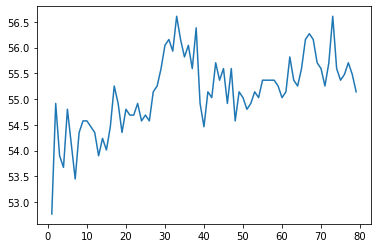

In [61]:
from sklearn.linear_model import LogisticRegression

range_of_accuracies = []

for i in range(1,len(X_test.columns)):
    clf_log = LogisticRegression(random_state = 25)
    y_fitted = model_train(clf_log, i)
    accuracy = accuracy_score(y_test, y_fitted)
    range_of_accuracies.append(accuracy*100)

plot_test(range_of_accuracies)

In [62]:
# Train model with number of features resulting in maximum accuracy

clf_log = LogisticRegression(random_state = 25)

y_fitted = model_train(clf_log, 33)

# Investigate F1 score of model
f1_score(y_test, y_fitted, average = None, labels = [0.0, 1.0])  

array([0.53623188, 0.59235669])